In [1]:
import ast
import torch
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Slowfast imports
from slowfast.models import build_model
from slowfast.utils.parser import load_config, alt_parse_args

from temporal_masking_utils import (
    get_feature_map,
    extract_framewise_features,
    calculate_masking_results,
)

plt.style.use("science")
plt.rcParams.update({"font.family": "Times New Roman"})

/home/dl18206/anaconda3/envs/slowfast/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/dl18206/anaconda3/envs/slowfast/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
train_path = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/fg_only/standard/train.csv"
val_path = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/fg_only/standard/val.csv"
metadata_path = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/with_negative_pairing/new_metadata.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

train_df.columns = ["subject_id", "label"]
val_df.columns = ["subject_id", "label"]

metadata = pd.read_csv(metadata_path)

with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/behaviours.txt",
    "rb",
) as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/segments.txt",
    "rb",
) as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

train_df = train_df.merge(
    metadata[["subject_id_fg", "value"]], right_on="subject_id_fg", left_on="subject_id"
)

val_df = val_df.merge(
    metadata[["subject_id_fg", "value"]], right_on="subject_id_fg", left_on="subject_id"
)


def is_fs(x):
    fs_behaviours = ["aggression"]
    for b in fs_behaviours:
        if b == x:
            return True
    for b in fs_behaviours:
        if b in x.split(","):
            return True
    return False


train_df[(train_df["value"].apply(is_fs))][["subject_id", "label", "value"]]

val_df[(val_df["value"].apply(is_fs))][["subject_id", "label", "value"]]

,subject_id,label,value
8,60910995.mp4,"[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]","display,aggression,piloerection,climbing,travel"
15,36070556.mp4,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","aggression,display,vocalisation"
20,36070537.mp4,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]","resting,travel,vocalisation,display,aggression"
24,36070523.mp4,"[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]","display,aggression,object_carrying,bipedal,cli..."
37,59759678.mp4,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","climbing,aggression,display"
54,36072978.mp4,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]","aggression,object_carrying,display"
59,36072994.mp4,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]","display,vocalisation,aggression,climbing,travel"
62,36072986.mp4,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]","aggression,vocalisation,display,travel"
68,36072949.mp4,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]","display,bipedal,object_carrying,aggression,voc..."
78,32836460.mp4,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]","camera_reaction,aggression,piloerection,vocali..."


In [5]:
# TODO: What do features from earlier layers tell us?

In [6]:
val_df_neg = pd.read_csv(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/with_negative_pairing/standard/val.csv"
)
val_df_neg.columns = ["fg", "bg", "label", "negative", "utm_code"]
val_df_neg = val_df_neg.merge(
    metadata[["subject_id_fg", "value"]], right_on="subject_id_fg", left_on="fg"
)[["fg", "bg", "label", "value"]]

fs_val_df_neg = val_df_neg[val_df_neg["value"].apply(is_fs)]
fs_labels = fs_val_df_neg.label

In [3]:
# Load the model
path_to_config = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/configs/SLOW_8x8_R50_Local_TEST.yaml"
path_to_ckpt = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/checkpoint_epoch_00200.pyth"

args = alt_parse_args()[:-1]
cfg = load_config(
    args[0],
    path_to_config=path_to_config,
)
checkpoint = torch.load(path_to_ckpt, map_location="cpu")

model = build_model(cfg)
model.load_state_dict(checkpoint["model_state"])
model.eval()
model.cpu()

classifier = model.head.projection

In [6]:
fg_fewshot = pd.read_pickle(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/r50_e100_fg_few_shot.pkl"
)
bg_fewshot = pd.read_pickle(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/r50_e100_bg_few_shot.pkl"
)

In [ ]:
sample_dict = {}

for i, (fg_sample, bg_sample, fg_name, bg_name, label) in enumerate(
    zip(
        fg_fewshot["feat_map"],
        bg_fewshot["feat_map"],
        fg_fewshot["name"],
        bg_fewshot["name"],
        fs_labels,
    )
):
    fg_framewise_features = (
        extract_framewise_features(fg_sample, t=16).permute(0, 2, 1).squeeze(0)
    )
    bg_framewise_features = (
        extract_framewise_features(bg_sample, t=16).permute(0, 2, 1).squeeze(0)
    )

    # Framewise logits
    fg_framewise_logits = []
    for feat in fg_framewise_features:
        fg_framewise_logits.append(torch.sigmoid(classifier(feat).detach()).numpy())
    fg_framewise_logits = np.array(fg_framewise_logits)

    bg_framewise_logits = []
    for feat in bg_framewise_features:
        bg_framewise_logits.append(torch.sigmoid(classifier(feat).detach()).numpy())
    bg_framewise_logits = np.array(bg_framewise_logits)

    # Video feats

    fg_video_features = F.adaptive_max_pool2d(
        fg_framewise_features.unsqueeze(0), (1, 2048)
    ).squeeze(0)

    # fg_video_features = F.adaptive_avg_pool3d(fg_sample, (1, 1, 1))
    fg_video_features = torch.flatten(fg_video_features, start_dim=1)

    # Video logits
    fg_video_logits = torch.sigmoid(classifier(fg_video_features)).detach().numpy()
    fg_video_logits = np.array(fg_video_logits)

    bg_video_features = F.adaptive_avg_pool3d(bg_sample, (1, 1, 1))
    bg_video_features = torch.flatten(bg_video_features, start_dim=1)

    bg_video_logits = torch.sigmoid(classifier(bg_video_features)).detach().numpy()
    bg_video_logits = np.array(bg_video_logits)

    sample_dict[fg_name[0]] = dict(
        fg_framewise_features=fg_framewise_features,
        fg_framewise_logits=fg_framewise_logits,
        fg_video_logits=fg_video_logits,
        bg_name=bg_name[0],
        bg_framewise_features=bg_framewise_features,
        bg_framewise_logits=bg_framewise_logits,
        bg_video_logits=bg_video_logits,
    )

    # Plot fg and bg frame-wise logits
    fig, ax = plt.subplots(
        1, 5, figsize=(20, 8), gridspec_kw={"width_ratios": [1.5, 1.5, 0.2, 0.2, 0.2]}
    )
    sns.heatmap(
        fg_framewise_logits.T,
        cmap="viridis",
        annot=True,
        yticklabels=behaviours,
        fmt=".2f",
        ax=ax[0],
    )
    sns.heatmap(
        bg_framewise_logits.T,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        ax=ax[1],
    )

    sns.heatmap(
        fg_video_logits.T,
        cmap="viridis",
        annot=True,
        ax=ax[2],
        fmt=".2f",
        cbar=False,
    )

    sns.heatmap(
        bg_video_logits.T,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        ax=ax[3],
        cbar=False,
    )

    sns.heatmap(
        np.expand_dims(np.squeeze(np.array(ast.literal_eval(label))), axis=0).T,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        ax=ax[4],
        cbar=False,
    )

    ax[0].title.set_text(f"FG Framewise Logits: {fg_name[0]}")
    ax[1].title.set_text(f"BG Framewise Logits: {bg_name[0]}")
    ax[2].title.set_text("FG Video Logits")
    ax[3].title.set_text("BG Video Logits")
    ax[4].title.set_text("Label")

    plt.tight_layout()

    plt.savefig(
        f"/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/figures/framewise_logits//avg_pool/frame_wise_logits_{fg_name[0].split('.')[0]}.pdf"
    )

    plt.show()

    if i == 0:
        break

In [4]:
fg_fewshot_train = torch.load(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/r50_e100_fg_few_shot_train.pkl"
)

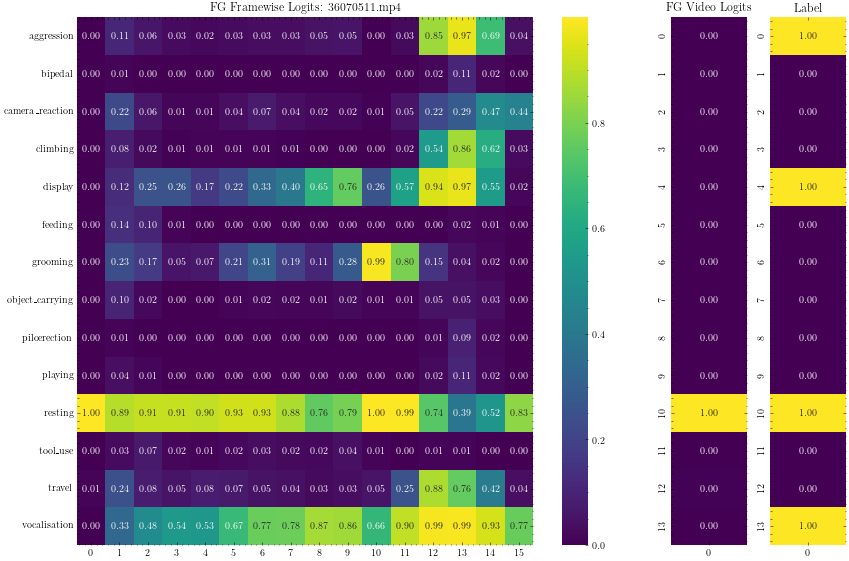

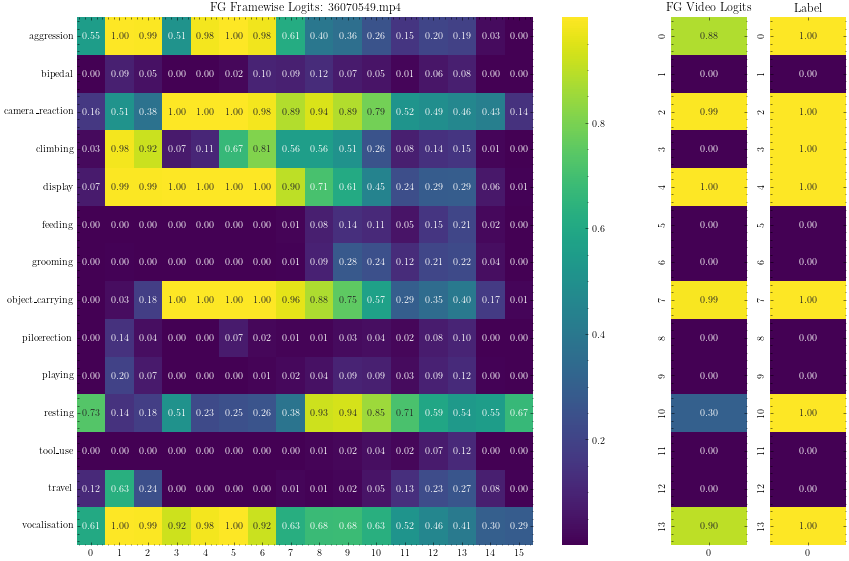

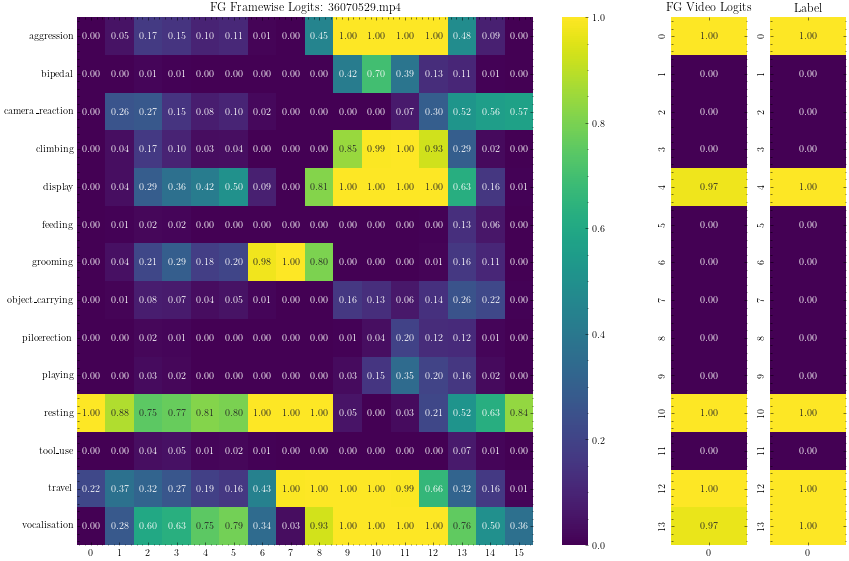

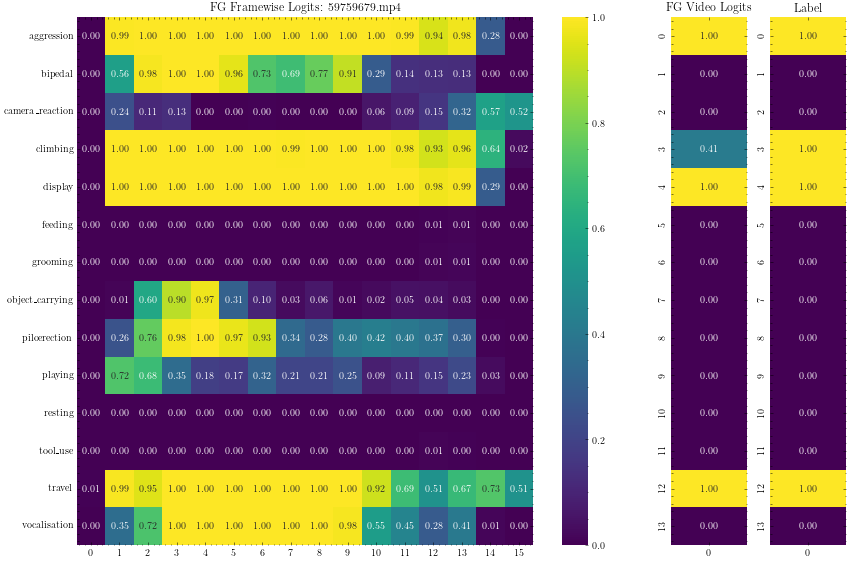

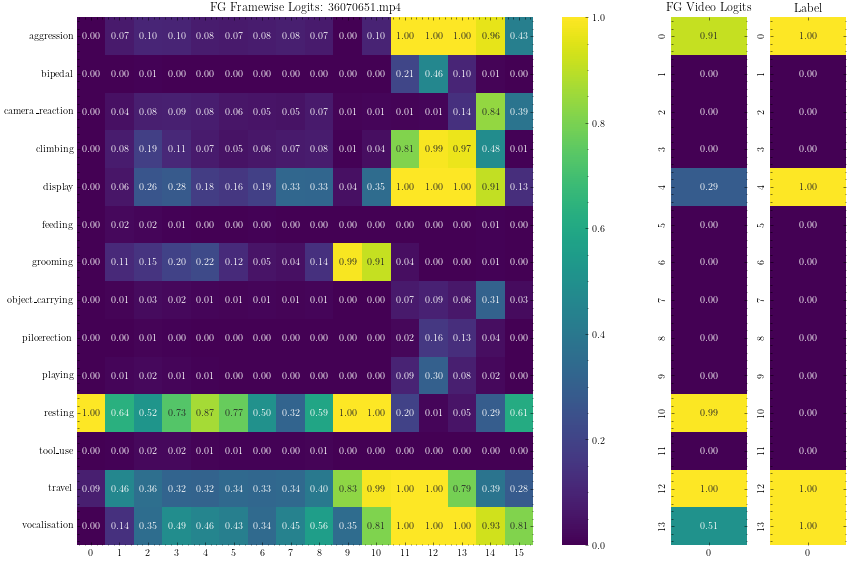

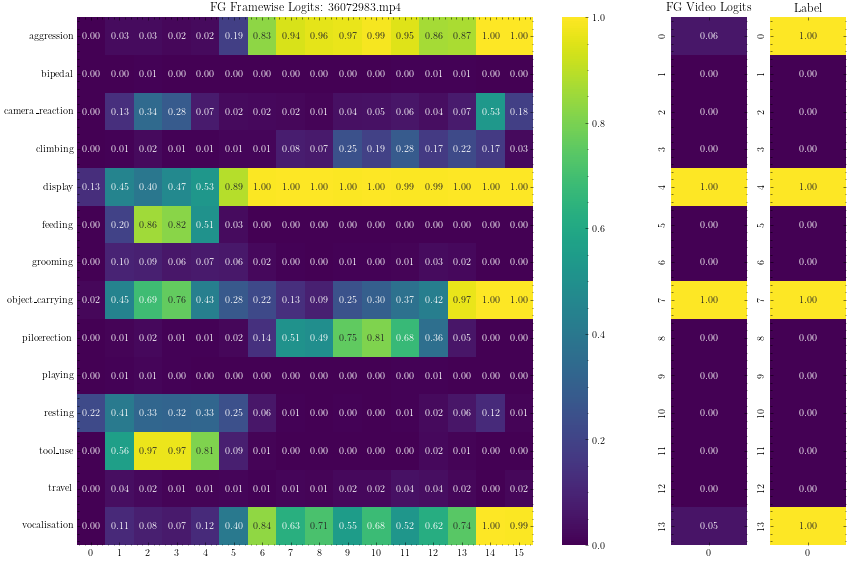

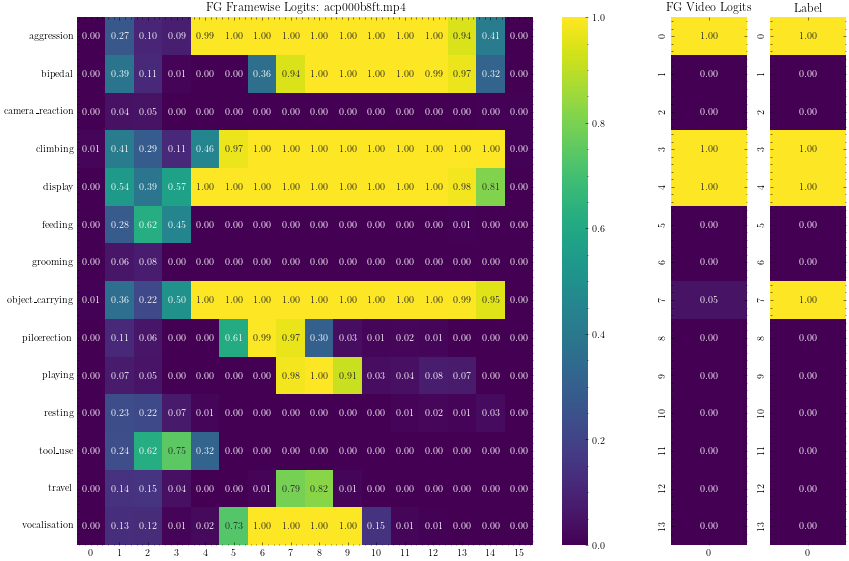

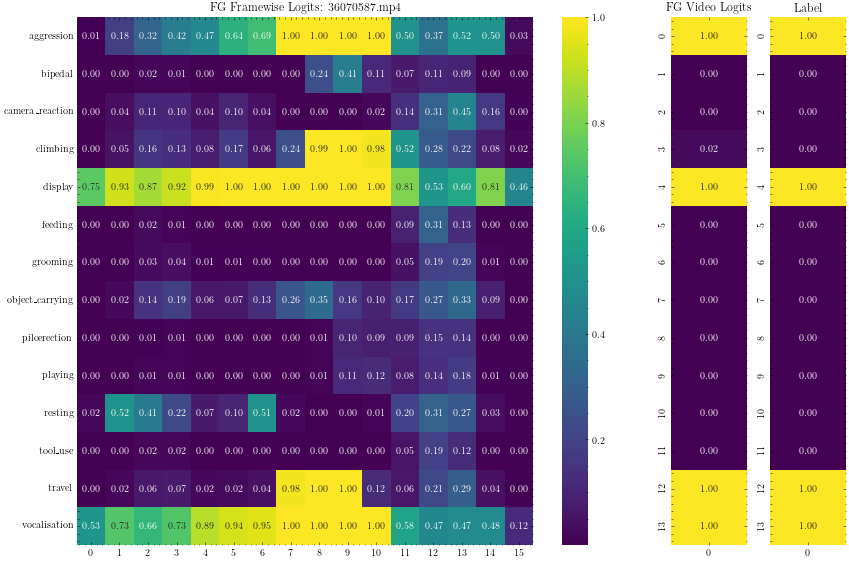

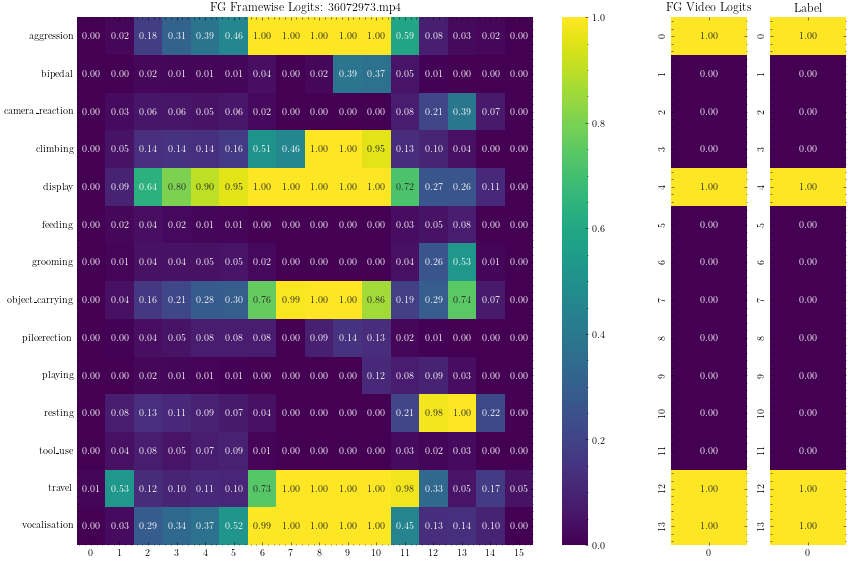

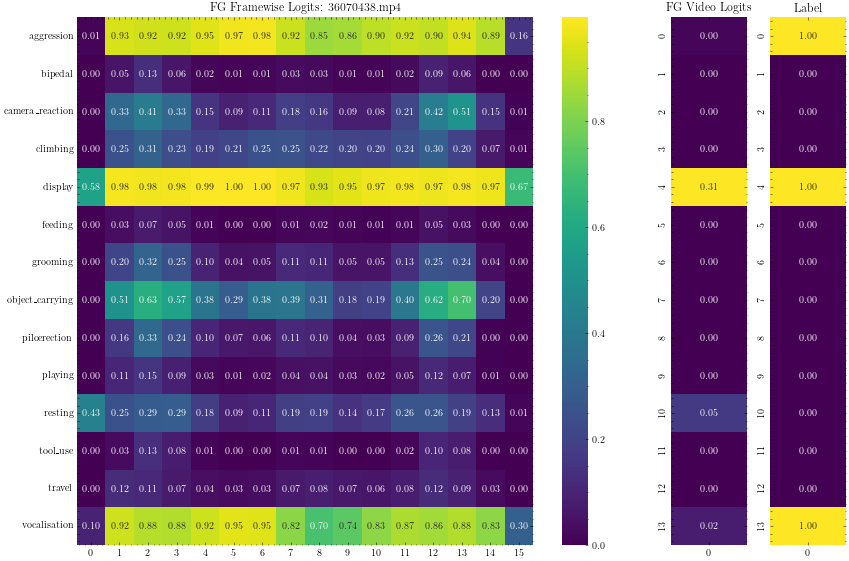

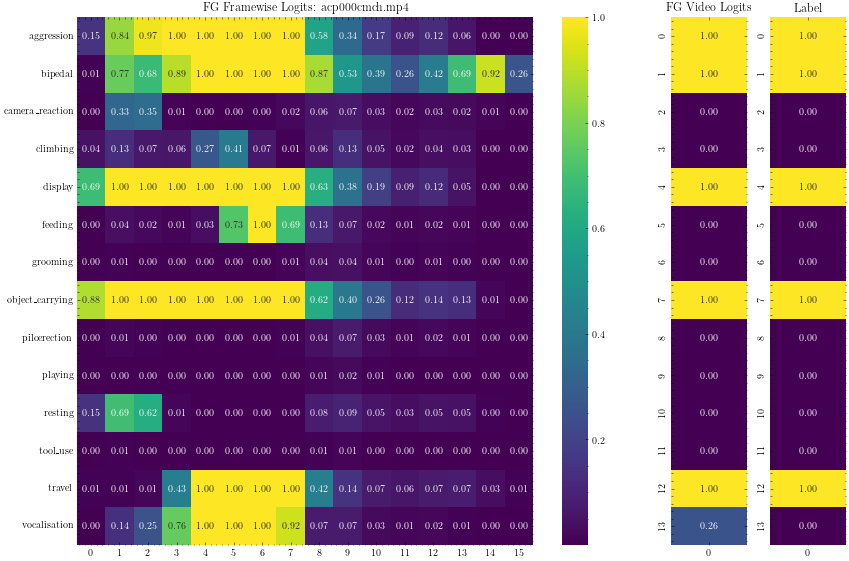

In [16]:
sample_dict = {}

for j, (fg_sample, fg_name, label) in enumerate(
    zip(
        fg_fewshot_train["feat_maps"],
        fg_fewshot_train["names"],
        fg_fewshot_train["labels"],
    )
):

    fg_framewise_features = (
        extract_framewise_features(fg_sample, t=16)
        .squeeze(0)
        .permute(2, 1, 0)
        .squeeze(0)
    )

    # Framewise logits
    fg_framewise_logits = []
    for feat in fg_framewise_features:
        fg_framewise_logits.append(torch.sigmoid(classifier(feat).detach()).numpy())
    fg_framewise_logits = np.array(fg_framewise_logits)

    # Video feats
    fg_video_features = F.adaptive_max_pool2d(
        fg_framewise_features.unsqueeze(0), (1, 2048)
    ).squeeze(0)

    # fg_video_features = F.adaptive_avg_pool3d(fg_sample, (1, 1, 1))
    fg_video_features = torch.flatten(fg_video_features, start_dim=1)

    # Video logits
    fg_video_logits = torch.sigmoid(classifier(fg_video_features)).detach().numpy()
    fg_video_logits = np.array(fg_video_logits)

    sample_dict[fg_name[0]] = dict(
        fg_framewise_features=fg_framewise_features,
        fg_framewise_logits=fg_framewise_logits,
        fg_video_logits=fg_video_logits,
    )

    # Plot fg and bg frame-wise logits
    fig, ax = plt.subplots(
        1, 3, figsize=(12, 8), gridspec_kw={"width_ratios": [1.5, 0.2, 0.2]}
    )
    sns.heatmap(
        fg_framewise_logits.T,
        cmap="viridis",
        annot=True,
        yticklabels=behaviours,
        fmt=".2f",
        ax=ax[0],
    )

    sns.heatmap(
        fg_video_logits.T,
        cmap="viridis",
        annot=True,
        ax=ax[1],
        fmt=".2f",
        cbar=False,
    )

    sns.heatmap(
        label.unsqueeze(0).T,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        ax=ax[2],
        cbar=False,
    )

    ax[0].title.set_text(f"FG Framewise Logits: {fg_name}")
    ax[1].title.set_text(f"FG Video Logits")
    ax[2].title.set_text("Label")

    plt.tight_layout()

    plt.show()

    if j == 10:
        break

In [13]:
fg_framewise_features.shape, fg_video_features.shape, fg_video_logits.shape

(torch.Size([16, 2048]), torch.Size([1, 2048]), (1, 14))

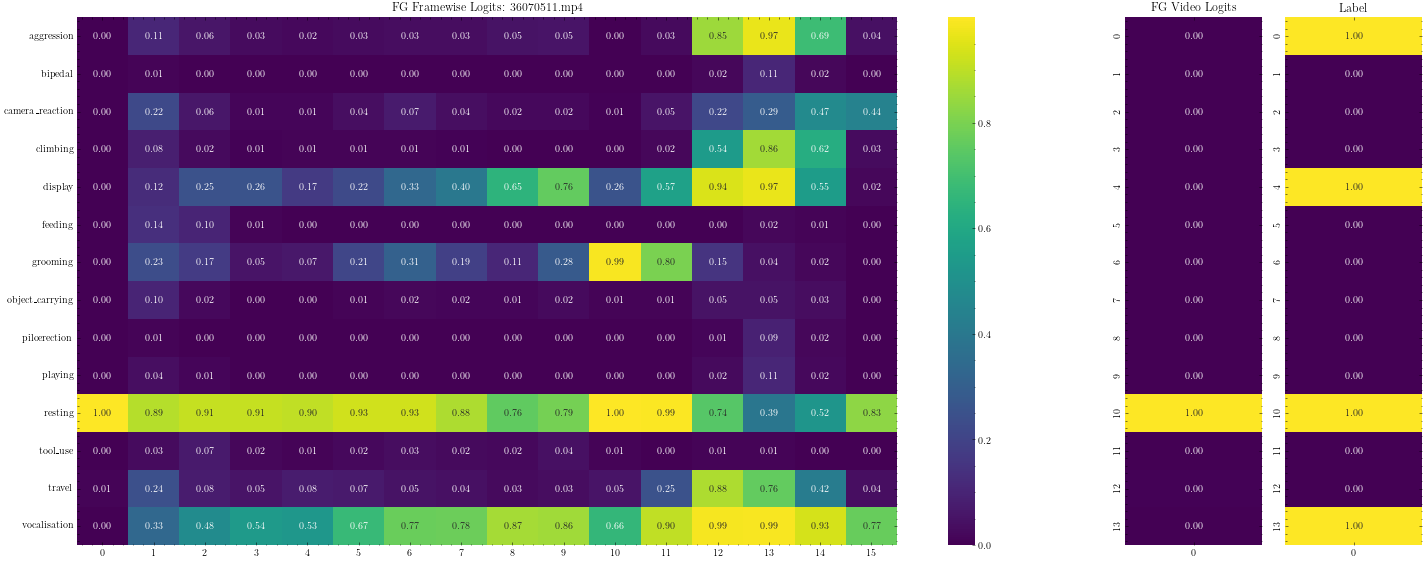

In [130]:
# Calculate the cosine similarity between the frame-wise features
def calculate_cosine_similarity(fg_framewise_features, normalize=True):
    # Input shape is (n_frames, n_features)
    n_frames = fg_framewise_features.shape[0]
    n_features = fg_framewise_features.shape[1]

    cosine_sim = np.zeros((n_frames, n_frames))

    for i in range(n_frames):
        for j in range(n_frames):
            if normalize:
                cosine_sim[i, j] /= np.linalg.norm(
                    fg_framewise_features[i]
                ) * np.linalg.norm(fg_framewise_features[j])
            else:
                cosine_sim[i, j] = np.dot(
                    fg_framewise_features[i], fg_framewise_features[j]
                )
    return cosine_sim

In [141]:
# Row wise normalise the framewise features
framewise_feats = (
    framewise_feats - framewise_feats.mean(axis=0)
) / framewise_feats.std(axis=0)

In [ ]:
# Plot the cosine similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim, cmap="viridis", annot=True, fmt=".1f")
plt.title("Cosine Similarity Matrix")
plt.show()

In [ ]:
pd.DataFrame(
    {
        "behaviour": behaviours,
        "preds": torch.sigmoid(
            classifier(
                sample_dict["36070149.mp4"]["fg_framewise_features"].min(axis=0)[0]
            )
        ).detach(),
    }
)

In [ ]:
sample_dict["36067981.mp4"]["fg_framewise_features"].shape

In [ ]:
sample_dict["36067981.mp4"]["fg_framewise_features"]

In [9]:
fg_fewshot["label"] = fs_labels.reset_index(drop=True)
labels = torch.tensor([ast.literal_eval(x) for x in fg_fewshot.label.tolist()])

In [ ]:
slice_results_df, slice_avg_df = calculate_masking_results(
    fg_fewshot,
    bg_fewshot,
    labels,
    classifier,
    behaviours,
    segments,
    weight_features_by_mask=False,
)

In [9]:
results_df, avg_df = calculate_masking_results(
    fg_fewshot,
    bg_fewshot,
    labels,
    classifier,
    behaviours,
    segments,
    weight_features_by_mask=True,
)

In [ ]:
avg_df[["original_f1", "weighted_f1@0.1", "weighted_f1@0.5", "weighted_f1@0.9"]]

In [ ]:
slice_avg_df[["original_f1", "weighted_f1@0.1", "weighted_f1@0.5", "weighted_f1@0.9"]]

In [ ]:
slice_results_df[
    [
        "behaviour",
        "original_f1",
        "weighted_f1@0.1",
        "weighted_f1@0.5",
        "weighted_f1@0.9",
    ]
]

**Meeting extension**

In [128]:
# Input video tensor
feature_map = fg_sample

In [ ]:
feature_map.shape

In [144]:
# Load the model
path_to_config = "../configs/SLOW_8x8_R50_Local_TEST.yaml"
path_to_ckpt = "../checkpoint_epoch_00200.pyth"

args = alt_parse_args()[:-1]
cfg = load_config(
    args[0],
    path_to_config=path_to_config,
)
checkpoint = torch.load(path_to_ckpt, map_location="cpu")

model = build_model(cfg)
model.load_state_dict(checkpoint["model_state"])
model.eval()
model.cpu()

classifier = model.head.projection

In [ ]:
model

In [ ]:
feature_map.shape

In [130]:
def extract_framewise_features(feature_map, t):
    spatially_pooled = F.adaptive_avg_pool3d(feature_map, (t, 1, 1))
    framewise_features = torch.flatten(spatially_pooled, start_dim=2)
    return framewise_features


def extract_video_features(feature_map):
    video_level_features = F.adaptive_avg_pool3d(feature_map, (1, 1, 1))
    video_level_features = torch.flatten(video_level_features, start_dim=1)
    return video_level_features

In [ ]:
framewise_features = extract_framewise_features(feature_map, t=16)
video_features = extract_video_features(feature_map)
print(f"Framewise features: {framewise_features.shape}")
print(f"Video-level features: {video_features.shape}")

In [134]:
# per-class weight norms
W = classifier.weight.cpu()
tmp = torch.linalg.norm(W, ord=2, dim=1).detach().numpy()
max_val, mid_val, min_val = tmp.max(), tmp.mean(), tmp.min()
c = min(1 / mid_val, mid_val)
y_range = [min_val - c, max_val + c]

In [ ]:
classifier.weight.shape

In [ ]:
w_norms = pd.DataFrame({"weight_norms": tmp, "behaviour": behaviours})
w_norms.sort_values("weight_norms", ascending=False)

In [136]:
# Framewise logits
fg_framewise_logits = []
for feat in fg_framewise_features:
    logit = classifier(feat)
    prob = torch.sigmoid(logit)
    fg_framewise_logits.append(prob.detach().numpy())
fg_framewise_logits = np.array(fg_framewise_logits)

In [ ]:
fg_framewise_logits.shape

In [142]:
# Video logits
fg_video_logits = torch.sigmoid(classifier(fg_video_features)).detach().numpy()

# Recover video features from framewise features
r_video_features = F.adaptive_max_pool1d(framewise_features, 1).squeeze(-1)
rfg_video_logits = torch.sigmoid(classifier(r_video_features)).detach().numpy()

In [ ]:
# Plot framewise logits
fig, ax = plt.subplots(
    1, 3, figsize=(10, 8), gridspec_kw={"width_ratios": [1, 0.1, 0.1]}, dpi=100
)
sns.heatmap(
    fg_framewise_logits.T,
    cmap="viridis",
    annot=True,
    yticklabels=behaviours,
    fmt=".2f",
    ax=ax[0],
    cbar=False,
)
sns.heatmap(
    fg_video_logits.T, cmap="viridis", annot=True, fmt=".2f", ax=ax[1], cbar=False
)

sns.heatmap(
    np.expand_dims(np.squeeze(np.array(ast.literal_eval(label))), axis=0).T,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    ax=ax[2],
    cbar=False,
)

In [ ]:
torch.sigmoid(classifier(torch.zeros(1, 2048) * 10))